## Notebook to explore downloaded metadata from Mapillary

In [1]:
from streetscapes.streetview import SVWorkspace
import contextily

In [ ]:
ws = SVWorkspace("Amsterdam")
metadata = ws.load_metadata()
metadata

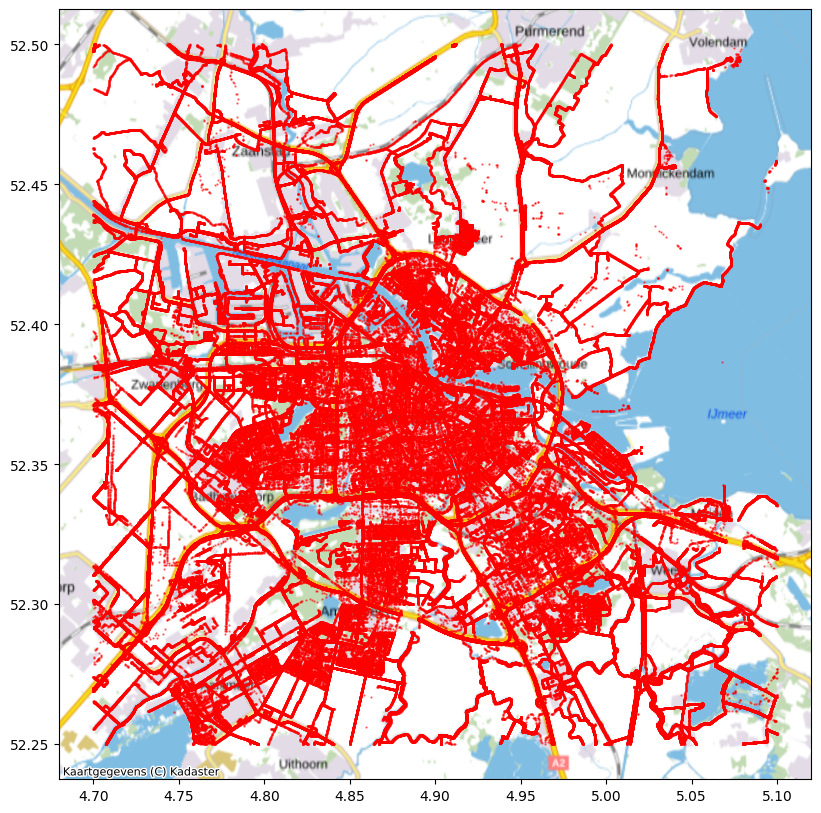

In [6]:
ax = metadata.plot(color="red", markersize=0.5, figsize=(10, 10), alpha=0.5)
contextily.add_basemap(
    ax, crs=metadata.crs, source=contextily.providers.nlmaps.standaard
)

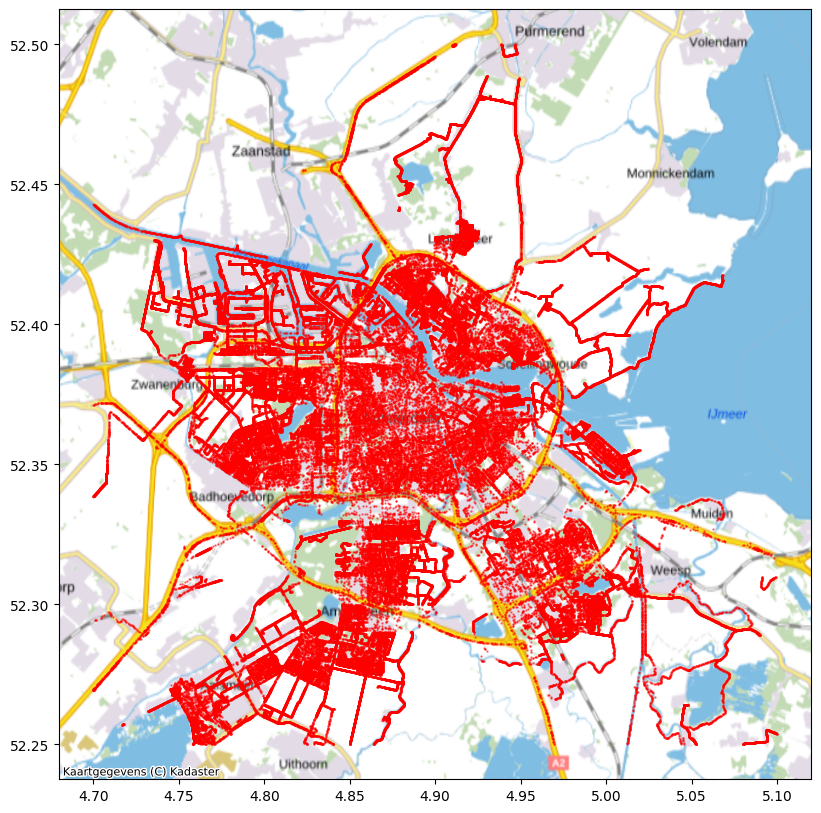

In [7]:
ax = metadata.query('is_pano').plot(color="red", markersize=0.5, figsize=(10, 10), alpha=0.5)
contextily.add_basemap(
    ax, crs=metadata.crs, source=contextily.providers.nlmaps.standaard
)